In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df=pd.read_csv(r'C:\Users\JATIN\OneDrive\Desktop\RSCCASN.csv',index_col='DATE' , parse_dates=True)

In [15]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [18]:
df.columns=['SALES']

In [19]:
df.head()

,SALES
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

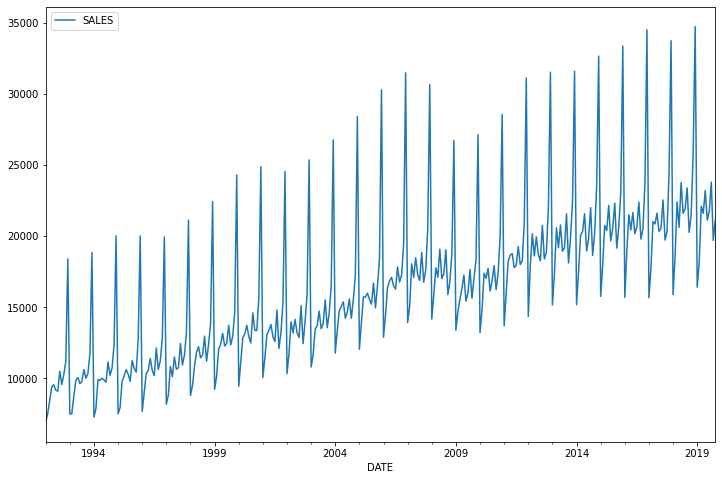

In [20]:
df.plot(figsize=(12,8))

In [21]:
len(df)-18

316

In [22]:
test_size=18

In [23]:
test_ind=len(df)-test_size

In [24]:
train=df.iloc[:test_ind]

In [25]:
test=df.iloc[test_ind:]

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler=MinMaxScaler()

In [28]:
scaler.fit(train)

MinMaxScaler()

In [29]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
length=12#batch length cannot be the same size as test length as we cannot predict the 19th element in test because there are a total of just 18 elements so predicting a 19th one makes no sense and we will get an error.
generator= TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [32]:
x,y=generator[0]

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [34]:
n_features=1

In [35]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [39]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [40]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])


Epoch 1/20


C:\Users\JATIN\AppData\Local\Temp\ipykernel_32368\2196276094.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 7s 13ms/step - loss: 0.0266 - val_loss: 0.0055
Epoch 2/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0198 - val_loss: 0.0067
Epoch 3/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0108 - val_loss: 7.2000e-04
Epoch 4/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 5/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0037 - val_loss: 4.5832e-04
Epoch 6/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 7/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0016 - val_loss: 0.0029


In [42]:
model.history.history

{'loss': [0.026574069634079933,
  0.019771968945860863,
  0.010823982767760754,
  0.00785695668309927,
  0.0037403961177915335,
  0.0027990846429020166,
  0.0016312204534187913],
 'val_loss': [0.005491374060511589,
  0.006674060132354498,
  0.0007200036197900772,
  0.0015354346251115203,
  0.00045832255273126066,
  0.001272590714506805,
  0.0029258260037750006]}

In [43]:
losses=pd.DataFrame(model.history.history)

<AxesSubplot:>

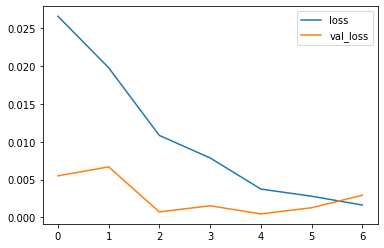

In [45]:
losses.plot()

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

1/1 [==============================] - 0s 61ms/step


In [49]:
true_predictions = scaler.inverse_transform(test_predictions)


In [50]:
test['PREDICTIONS']=true_predictions

C:\Users\JATIN\AppData\Local\Temp\ipykernel_32368\2611319349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICTIONS']=true_predictions


In [51]:
test

,SALES,PREDICTIONS
DATE,,
2018-05-01,23764,22446.525299
2018-06-01,21589,21341.658516
2018-07-01,21919,21615.898134
2018-08-01,23381,23499.209047
2018-09-01,20260,21038.786773
2018-10-01,21473,21727.960729
2018-11-01,25831,25939.237499
2018-12-01,34706,35832.099956
2019-01-01,16410,17254.659784


<AxesSubplot:xlabel='DATE'>

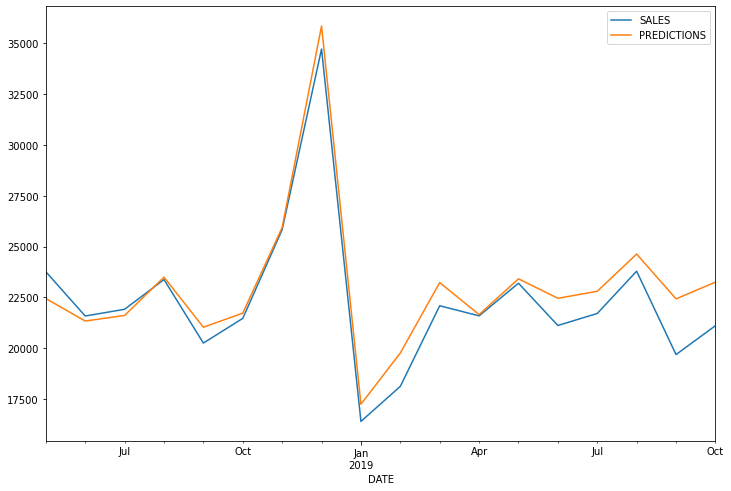

In [52]:
test.plot(figsize=(12,8))

In [54]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df) #scaling the whole dataframe at once

In [55]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [56]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


C:\Users\JATIN\AppData\Local\Temp\ipykernel_32368\853647718.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 7s 10ms/step - loss: 0.0264
Epoch 2/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0175
Epoch 3/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0109
Epoch 4/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0064
Epoch 5/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0036
Epoch 6/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 7/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0025
Epoch 8/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0019


In [57]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 55ms/step


In [58]:
forecast=scaler.inverse_transform(forecast)

In [59]:
forecast

array([[25219.73056412],
       [32426.36112118],
       [17358.92981005],
       [18877.93304014],
       [21890.8174367 ],
       [21556.29767179],
       [22784.52885818],
       [21211.24279499],
       [21726.2828598 ],
       [23302.15960503],
       [20224.19047904],
       [21415.82951307]])

In [60]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [68]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [69]:
forecast_df

,Forecast
2019-11-01,25219.730564
2019-12-01,32426.361121
2020-01-01,17358.929810
2020-02-01,18877.933040
2020-03-01,21890.817437
2020-04-01,21556.297672
2020-05-01,22784.528858
2020-06-01,21211.242795
2020-07-01,21726.282860
2020-08-01,23302.159605


<AxesSubplot:xlabel='DATE'>

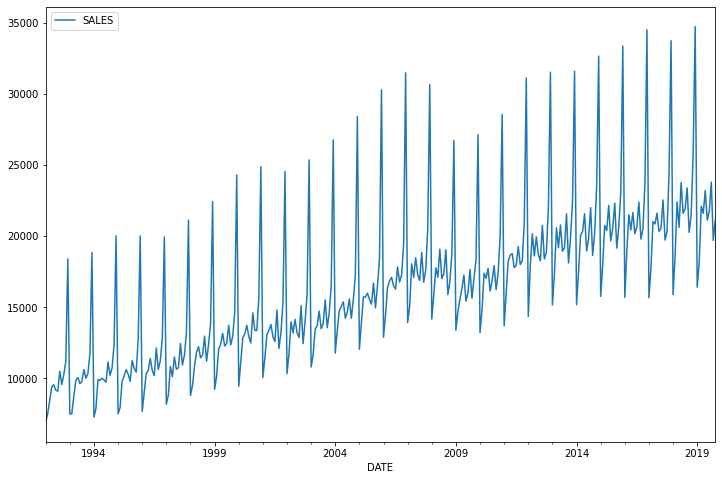

In [73]:
df.plot(figsize=(12,8))

<AxesSubplot:>

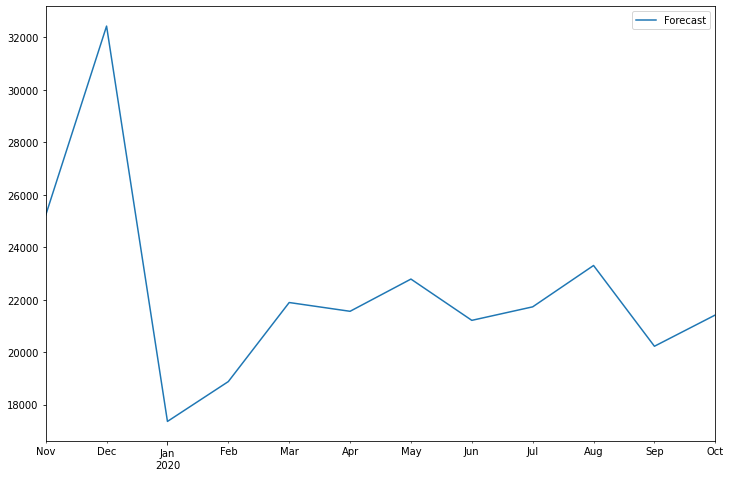

In [70]:
forecast_df.plot(figsize=(12,8))

<AxesSubplot:xlabel='DATE'>

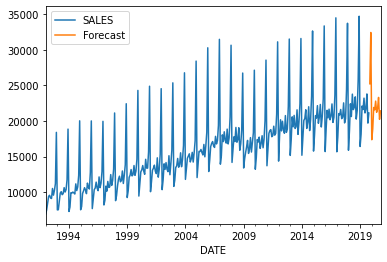

In [77]:
axis=df.plot()
forecast_df.plot(ax=axis)